# 1. Используемые модули 

In [1]:
import numpy as np
from scipy.signal import correlate  
from scipy.fftpack import fft, fftfreq, fftshift, ifft    # модули для вычисления БПФ и ОБПФ
import matplotlib.pyplot as plt                           # модуль для отображения графиков
from matplotlib import animation

# 2. Параметры дальномерного кода сигнала B3I

In [2]:
phase0 = 0
code_length = 10230
chip_rate = code_length * 1000 

secondary_code = np.array([0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0])
secondary_code = 1.0 - 2.0*secondary_code

b3i_g2_initial = {
   1: "1010111111111",   2: "1111000101011",   3: "1011110001010",   4: "1111111111011",
   5: "1100100011111",   6: "1001001100100",   7: "1111111010010",   8: "1110111111101",
   9: "1010000000010",  10: "0010000011011",  11: "1110101110000",  12: "0010110011110",
  13: "0110010010101",  14: "0111000100110",  15: "1000110001001",  16: "1110001111100",
  17: "0010011000101",  18: "0000011101100",  19: "1000101010111",  20: "0001011011110",
  21: "0010000101101",  22: "0010110001010",  23: "0001011001111",  24: "0011001100010",
  25: "0011101001000",  26: "0100100101001",  27: "1011011010011",  28: "1010111100010",
  29: "0001011110101",  30: "0111111111111",  31: "0110110001111",  32: "1010110001001",
  33: "1001010101011",  34: "1100110100101",  35: "1101001011101",  36: "1111101110100",
  37: "0010101100111",  38: "1110100010000",  39: "1101110010000",  40: "1101011001110",
  41: "1000000110100",  42: "0101111011001",  43: "0110110111100",  44: "1101001110001",
  45: "0011100100010",  46: "0101011000101",  47: "1001111100110",  48: "1111101001000",
  49: "0000101001001",  50: "1000010101100",  51: "1111001001100",  52: "0100110001111",
  53: "0000000011000",  54: "1000000000100",  55: "0011010100110",  56: "1011001000110",
  57: "0111001111000",  58: "0010111001010",  59: "1100111110110",  60: "1001001000101",
  61: "0111000100000",  62: "0011001000010",  63: "0010001001110",
}

# 3. Используемые функции

## 3.1 Функции формирования кода ПСП

In [3]:
def b3i_g1_shift(x):
    if x==[1,1,1,1,1,1,1,1,1,1,1,0,0]:
        return [1,1,1,1,1,1,1,1,1,1,1,1,1]
    else:
        return [x[0]^x[2]^x[3]^x[12]] + x[0:12]
    
def b3i_g2_shift(x):
    return [x[0]^x[4]^x[5]^x[6]^x[8]^x[9]^x[11]^x[12]] + x[0:12]

def b3i(prn):
    n = code_length
    g1 = [1,1,1,1,1,1,1,1,1,1,1,1,1]
    g2 = str2list(b3i_g2_initial[prn])
    b3i = np.zeros(n)
    for i in range(n):
        b3i[i] = g1[12] ^ g2[12]
        g1 = b3i_g1_shift(g1)
        g2 = b3i_g2_shift(g2)
    return b3i

def b3i_code(prn):
    return b3i(prn)

def code(prn,chips,frac,incr,n):
    c = b3i_code(prn)
    idx = (chips % code_length) + frac + incr*np.arange(n)
    idx = np.floor(idx).astype('int')
    idx = np.mod(idx, code_length)
    x = c[idx]
    return 1.0 - 2.0*x

## 3.2 Функции преобразования значений 

In [4]:
def transformToBPSK(code):
    return [-1.0 if i == 0 else i for i in code]

def str2list(s):         
    return [int(x) for x in s]

## 3.3 Функции вычисления характеристик

In [21]:
def resultCorrelate(__input1, __input2):
    N = len(__input1)
    acorr = correlate(__input1, __input2, 'full')
    offsetPhase = np.arange(-N+1, N)
    return [offsetPhase, acorr]

def funcFFT(__input_signal, k_rate): # функция вычисления БПФ
    yf = fft(__input_signal)
    maxVal = max(np.abs(yf))
    yf = yf / maxVal
    xf = fftfreq(len(yf), 1 / (chip_rate*k_rate))
    return [xf, yf]

def spdFM2(__freq, __fc):
    buffer = (__freq)/__fc
    buffer = np.power(np.sinc(buffer), 2)
    return buffer

def correlateFFT(x, y):
    return ifft(fft(x) * fft(y).conj()).real

# 4. Исследование дальномерного кода

## 4.1 Формирование 4 различных кодов 

In [6]:
code1 = b3i_code(1)
code2 = b3i_code(2)
code3 = b3i_code(3)
code4 = b3i_code(4)
stamp = [i for i in range(code_length)] 

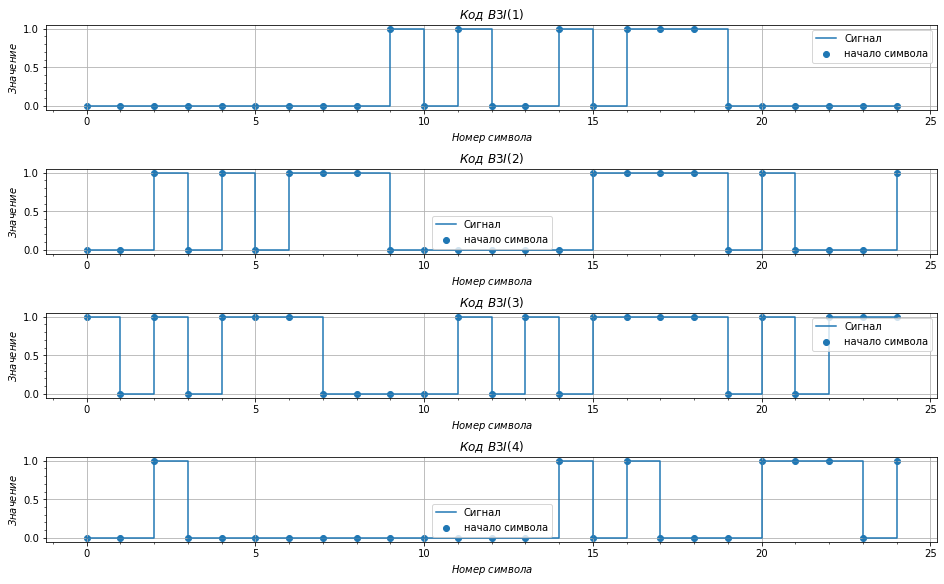

In [7]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(411)
plt.step(stamp[:25], code1[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code1[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(1)$')
plt.legend()
plt.grid(True)

sp = plt.subplot(412)
plt.step(stamp[:25], code2[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code2[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(2)$')
plt.legend()
plt.grid(True)

sp = plt.subplot(413)
plt.step(stamp[:25], code3[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code3[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(3)$')
plt.legend()
plt.grid(True)

sp = plt.subplot(414)
plt.step(stamp[:25], code4[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code4[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(4)$')
plt.legend()
plt.grid(True)

plt.show()

## 4.2 Преобразование к BPSK

In [8]:
code1BPSK = transformToBPSK(code1)
code2BPSK = transformToBPSK(code2)
code3BPSK = transformToBPSK(code3)
code4BPSK = transformToBPSK(code4)

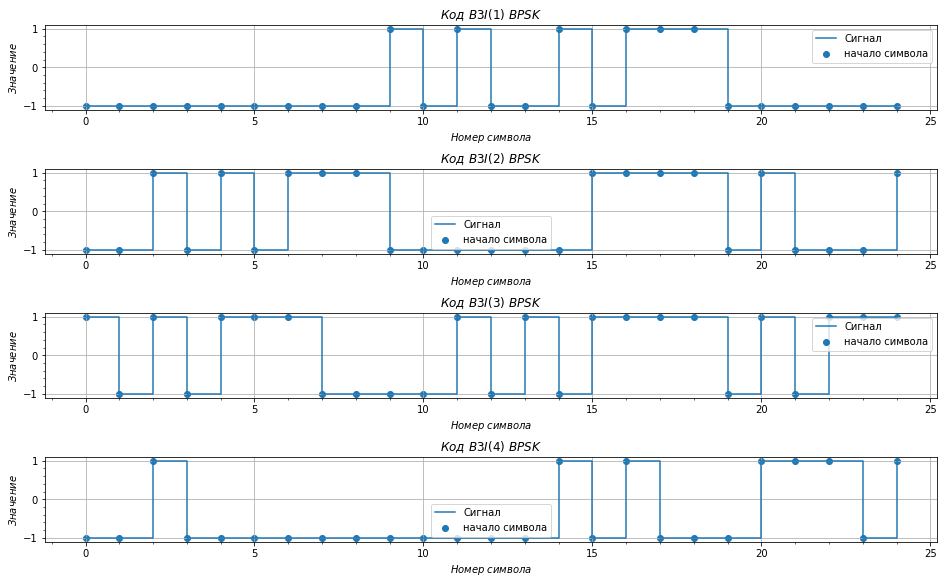

In [9]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(411)
plt.step(stamp[:25], code1BPSK[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code1BPSK[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(1)\ BPSK$')
plt.legend()
plt.grid(True)

sp = plt.subplot(412)
plt.step(stamp[:25], code2BPSK[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code2BPSK[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(2)\ BPSK$')
plt.legend()
plt.grid(True)

sp = plt.subplot(413)
plt.step(stamp[:25], code3BPSK[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code3BPSK[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(3)\ BPSK$')
plt.legend()
plt.grid(True)

sp = plt.subplot(414)
plt.step(stamp[:25], code4BPSK[:25], where = 'post', label='Cигнал')
plt.scatter(stamp[:25], code4BPSK[:25], label='начало символа')
plt.minorticks_on()
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel(r'$Значение$')
plt.title(r'$Код\ B3I(4)\ BPSK$')
plt.legend()
plt.grid(True)

plt.show()

## 4.3 АКФ периодического кода

In [10]:
code1_periodical = 4 * code1BPSK 
code2_periodical = 4 * code2BPSK
code3_periodical = 4 * code3BPSK
code4_periodical = 4 * code4BPSK

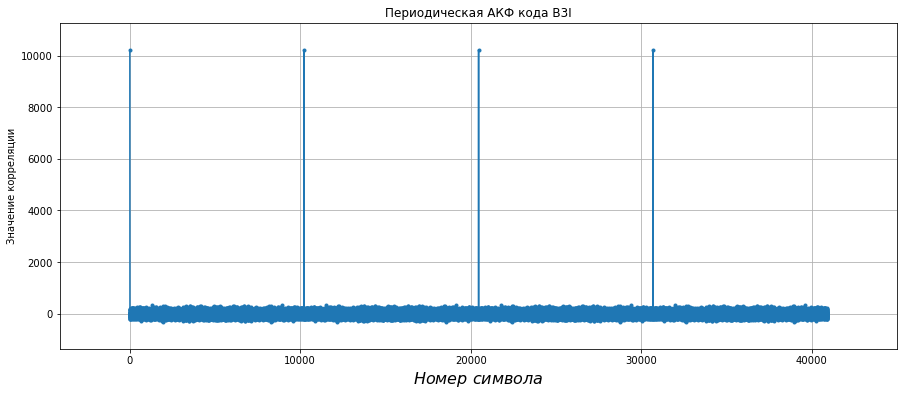

In [11]:
resultAKF = resultCorrelate(code1_periodical, np.concatenate((code1BPSK,np.zeros(len(code1BPSK)*3))))
a = correlateFFT(code1_periodical, np.concatenate((code1BPSK,np.zeros(len(code1BPSK)*3))))
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(a)), a, '.-') #resultAKF[0]
#plt.plot(resultAKF[0], resultAKF[1], '.-') #
plt.margins(0.1, 0.1)
plt.xlabel(r'$Номер\ символа$', fontsize=16) 
plt.ylabel("Значение корреляции")
plt.title("Периодическая АКФ кода B3I")
plt.grid(True)
plt.show()

## 4.4 ВКФ сформированных кодов

In [12]:
resultBKF1 = resultCorrelate(code1BPSK, code1BPSK)
resultBKF2 = resultCorrelate(code1BPSK, code2BPSK)
resultBKF3 = resultCorrelate(code1BPSK, code3BPSK)
resultBKF4 = resultCorrelate(code1BPSK, code4BPSK)

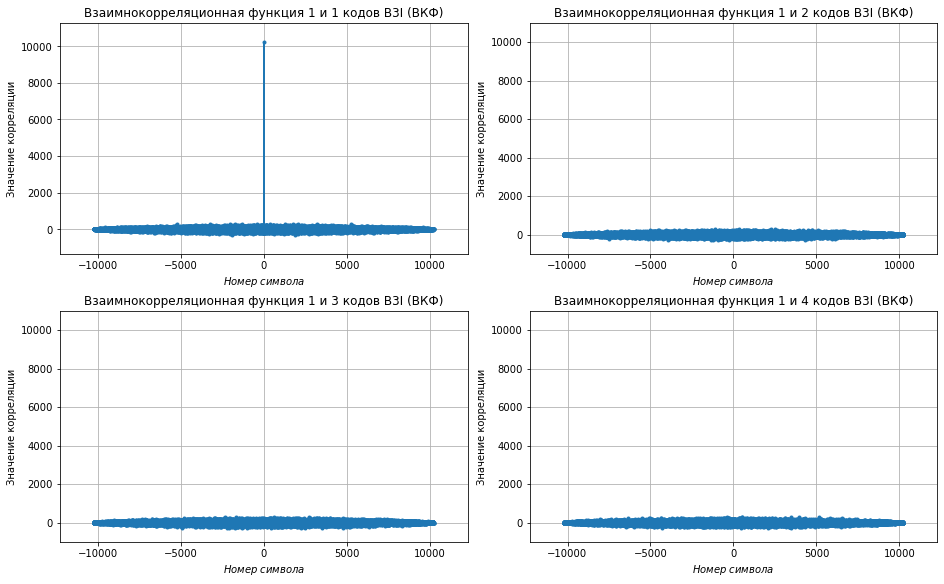

In [13]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(221)
plt.plot(resultBKF1[0], resultBKF1[1], '.-') #
plt.margins(0.1, 0.1)
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel("Значение корреляции")
plt.title("Взаимнокорреляционная функция 1 и 1 кодов B3I (ВКФ)")
plt.grid(True)

sp = plt.subplot(222)
plt.plot(resultBKF2[0], resultBKF2[1], '.-') #
plt.margins(0.1, 0.1)
plt.ylim([-1000, 11000])
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel("Значение корреляции")
plt.title("Взаимнокорреляционная функция 1 и 2 кодов B3I (ВКФ)")
plt.grid(True)

sp = plt.subplot(223)
plt.plot(resultBKF3[0], resultBKF3[1], '.-') #
plt.margins(0.1, 0.1)
plt.ylim([-1000, 11000])
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel("Значение корреляции")
plt.title("Взаимнокорреляционная функция 1 и 3 кодов B3I (ВКФ)")
plt.grid(True)

sp = plt.subplot(224)
plt.plot(resultBKF4[0], resultBKF4[1], '.-') #
plt.margins(0.1, 0.1)
plt.ylim([-1000, 11000])
plt.xlabel(r'$Номер\ символа$', fontsize=10) 
plt.ylabel("Значение корреляции")
plt.title("Взаимнокорреляционная функция 1 и 4 кодов B3I (ВКФ)")
plt.grid(True)

plt.show()

## 4.5 СПМ ПСП при одном отсчёте на символ 

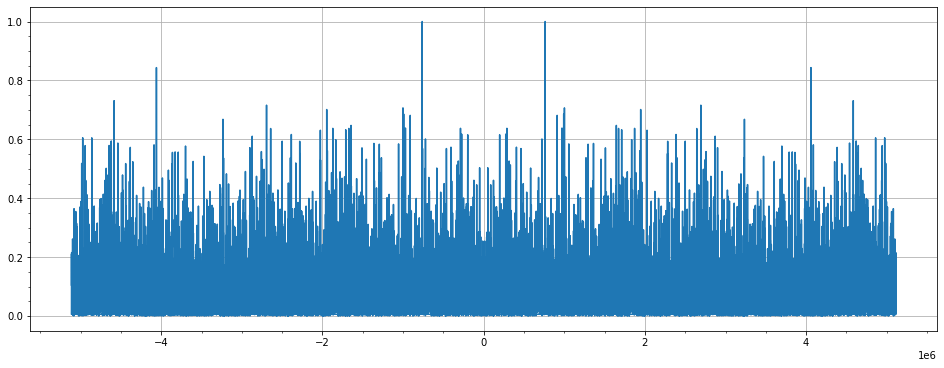

In [14]:
ffts = funcFFT(resultBKF1[1], 1)

plt.figure(figsize=(13, 5), constrained_layout=True)
plt.plot(ffts[0], np.abs(ffts[1])) #ffts[0]
plt.minorticks_on()
plt.grid(True)

## 4.6 СПМ ПСП при 10-ти отсчётах на символ 

In [15]:
numOfSamPerSym = 2
repeat_code = list(np.repeat(code1BPSK, numOfSamPerSym))

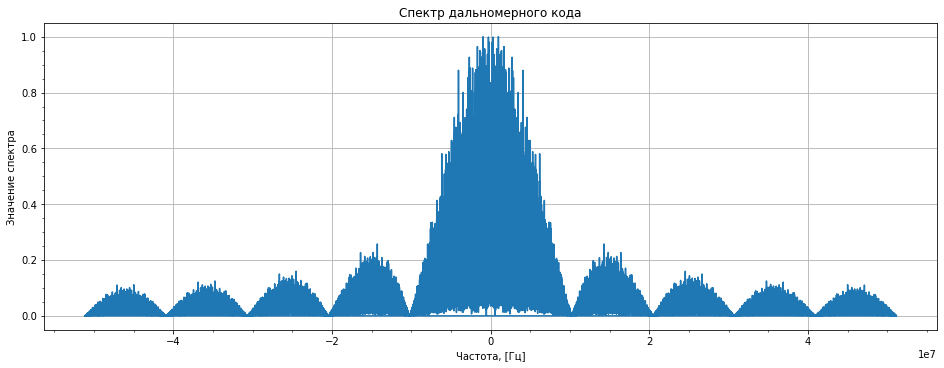

In [16]:
ffts = funcFFT(repeat_code, numOfSamPerSym)

plt.figure(figsize=(13, 5), constrained_layout=True)
plt.plot(ffts[0], np.abs(ffts[1])) #ffts[0]
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение спектра")
plt.title("Спектр дальномерного кода")
plt.minorticks_on()
plt.grid(True)

In [17]:
resultRepeatAKF = resultCorrelate(repeat_code, repeat_code)
ffts = funcFFT(resultRepeatAKF[1], numOfSamPerSym)
spdReal = spdFM2(ffts[0], chip_rate)

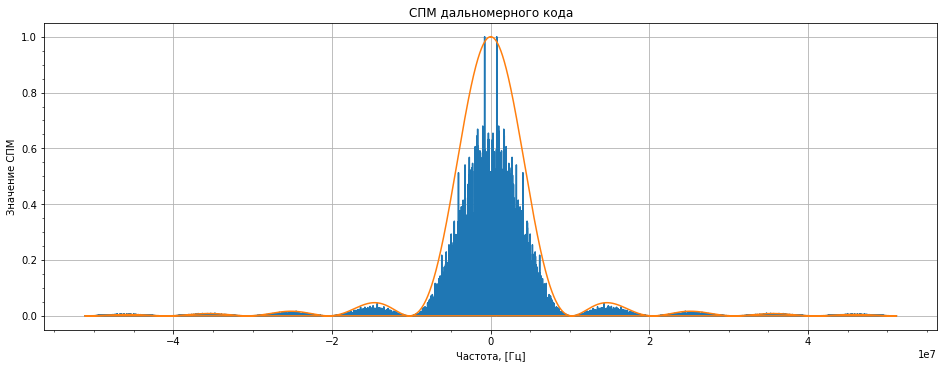

In [18]:
plt.figure(figsize=(13, 5), constrained_layout=True)
plt.plot(ffts[0], np.abs(ffts[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ дальномерного кода")
plt.minorticks_on()
plt.grid(True)

## 4.7 Сравнение СПМ ПСП от количества периодов кода в сигнале

In [22]:
code1_periodical_1 = 1 * repeat_code 
code1_periodical_2 = 2 * repeat_code
code1_periodical_5 = 5 * repeat_code
code1_periodical_50 = 50 * repeat_code

In [23]:
resultPeriodicalAKF_1 = resultCorrelate(code1_periodical_1, code1_periodical_1)
resultPeriodicalAKF_2 = resultCorrelate(code1_periodical_2, code1_periodical_2)
resultPeriodicalAKF_5 = resultCorrelate(code1_periodical_5, code1_periodical_5)
resultPeriodicalAKF_50 = resultCorrelate(code1_periodical_50, code1_periodical_50)

In [27]:
ffts_1 = funcFFT(resultPeriodicalAKF_1[1], numOfSamPerSym)
ffts_2 = funcFFT(resultPeriodicalAKF_2[1], numOfSamPerSym)
ffts_5 = funcFFT(resultPeriodicalAKF_5[1], numOfSamPerSym)
ffts_50 = funcFFT(resultPeriodicalAKF_50[1], numOfSamPerSym)

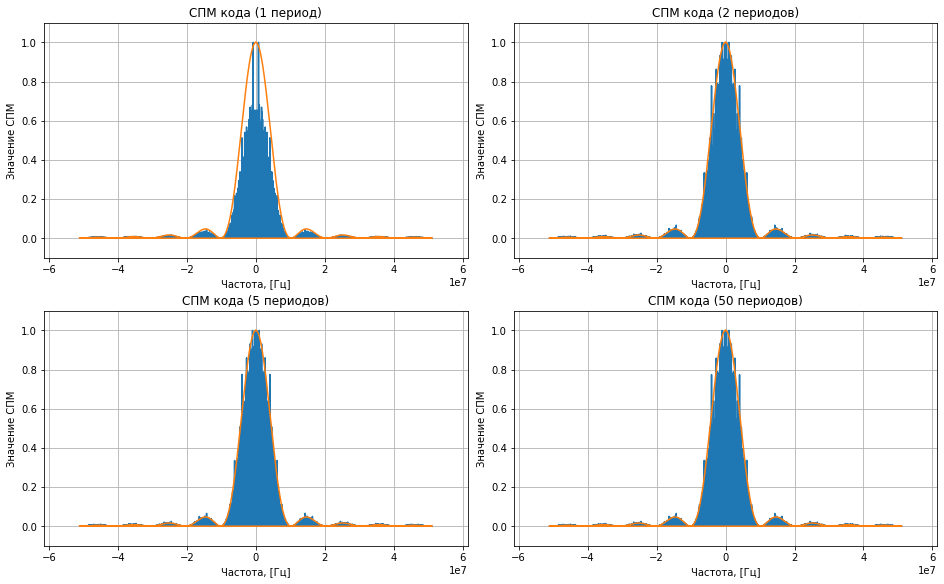

In [28]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(221)
plt.plot(ffts_1[0], np.abs(ffts_1[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (1 период)")
plt.grid(True)

sp = plt.subplot(222)
plt.plot(ffts_2[0], np.abs(ffts_2[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (2 периодов)")
plt.grid(True)

sp = plt.subplot(223)
plt.plot(ffts_5[0], np.abs(ffts_5[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (5 периодов)")
plt.grid(True)

sp = plt.subplot(224)
plt.plot(ffts_50[0], np.abs(ffts_50[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (50 периодов)")
plt.grid(True)

plt.show()

## 4.8 Сравнение СПМ ПСП от количества отсчётов в символе кода

In [29]:
repeat_code_1 = np.repeat(code1BPSK, 1)
repeat_code_2 = np.repeat(code1BPSK, 2)
repeat_code_4 = np.repeat(code1BPSK, 4)
repeat_code_10 = np.repeat(code1BPSK, 10)

In [30]:
resultRepeatAKF_1 = resultCorrelate(repeat_code_1, repeat_code_1)
resultRepeatAKF_2 = resultCorrelate(repeat_code_2, repeat_code_2)
resultRepeatAKF_4 = resultCorrelate(repeat_code_4, repeat_code_4)
resultRepeatAKF_10 = resultCorrelate(repeat_code_10, repeat_code_10)

In [31]:
ffts_1 = funcFFT(resultRepeatAKF_1[1], 1)
ffts_2 = funcFFT(resultRepeatAKF_2[1], 2)
ffts_4 = funcFFT(resultRepeatAKF_4[1], 4)
ffts_10 = funcFFT(resultRepeatAKF_10[1], 10)

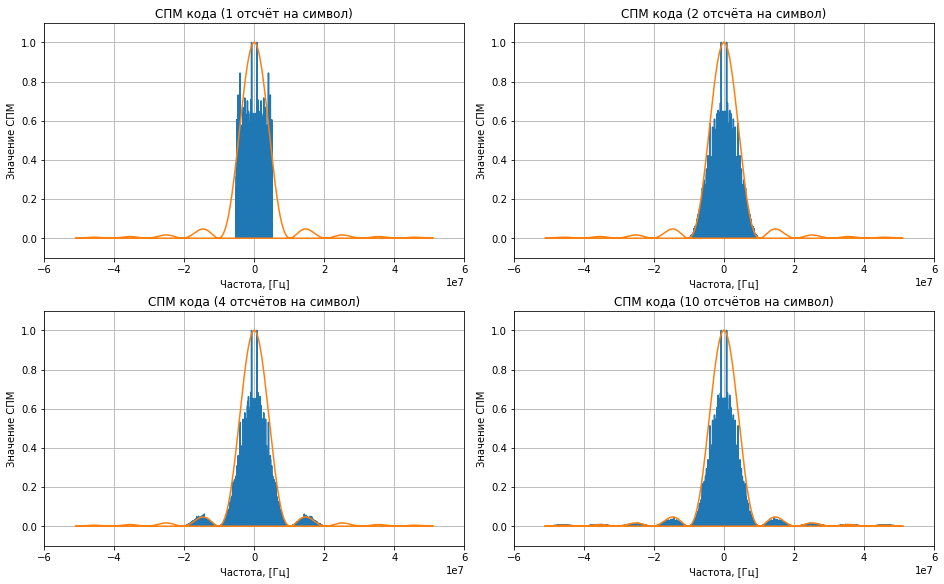

In [32]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(221)
plt.plot(ffts_1[0], np.abs(ffts_1[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlim([-6e+7, 6e+7])
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (1 отсчёт на символ)")
plt.grid(True)

sp = plt.subplot(222)
plt.plot(ffts_2[0], np.abs(ffts_2[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlim([-6e+7, 6e+7])
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (2 отсчётa на символ)")
plt.grid(True)

sp = plt.subplot(223)
plt.plot(ffts_4[0], np.abs(ffts_4[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlim([-6e+7, 6e+7])
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (4 отсчётов на символ)")
plt.grid(True)

sp = plt.subplot(224)
plt.plot(ffts_10[0], np.abs(ffts_10[1])) 
plt.plot(ffts[0], np.abs(spdReal))
plt.margins(0.1, 0.1)
plt.xlim([-6e+7, 6e+7])
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение СПМ")
plt.title("СПМ кода (10 отсчётов на символ)")
plt.grid(True)

plt.show()

# 5. Исследование квадратурного уплотнения сигнала

## 5.1 Параметры сигнала

In [33]:
fs = chip_rate * 16
dt = 1/fs                      # интервал следования отсчётов [с]
phase0 = 0
fcar = chip_rate * 2
n_samples = code_length * 16
time = np.arange(n_samples)*dt # массив временнных отсчётов 

## 5.2 Функции преобразования в отсчёты и генерации составляющих

In [34]:
def resampleCode(_code, _fs, _fc, _phase0, _n_samples): # преобразование символов кода в отсчёты 
    code_len = len(_code) # длина массива
    phase = _phase0 + np.arange(_n_samples)*(_fc/_fs)
    phase = np.floor(np.mod(phase, code_len))
    phase = phase.astype(np.int32) # преобразование к целым значениям для индексации массива
    code_samples = _code[phase]
    return code_samples

def carrExpGen(_fs, _fс, _phase0, _n_samples, _IQ): # генерация несущего сигнала
    phase = np.pi*_phase0/180 + 2*np.pi*np.arange(_n_samples)*(_fс/_fs)
    carrier_samples = np.exp(_IQ*1j*phase)
    return carrier_samples

def carrCosGen(_fs, _fс, _phase0, _n_samples): # генерация несущего сигнала
    phase = np.pi*_phase0/180 + 2*np.pi*np.arange(_n_samples)*(_fс/_fs)
    carrier_samples = np.cos(phase)
    return carrier_samples

def carrSinGen(_fs, _fс, _phase0, _n_samples): # генерация несущего сигнала
    phase = np.pi*_phase0/180 + 2*np.pi*np.arange(_n_samples)*(_fс/_fs)
    carrier_samples = np.sin(phase)
    return carrier_samples

## 5.3 Непосредственное вычисление

In [39]:
code_samples_1 = resampleCode(np.array(code1BPSK), fs, chip_rate, phase0, n_samples)
code_samples_2 = resampleCode(np.array(code1BPSK), fs, chip_rate, 10, n_samples)

carCos_samples = carrCosGen(fs, fcar, phase0, n_samples)            # несущая Cos
carSin_samples = carrSinGen(fs, fcar, phase0, n_samples)            # несущая Sin
carExp_samples = carrExpGen(fs, fcar, phase0, n_samples, 1)         # несущая Exp

signalCos = carCos_samples * code_samples_1
signalSin = carSin_samples * code_samples_2
signalExp = carExp_samples * code_samples_1

signalMixed = signalCos + signalSin

In [40]:
fftCos = funcFFT(signalCos, 16)
fftExp = funcFFT(signalExp, 16)
fftSin = funcFFT(signalSin, 16)
fftMixed = funcFFT(signalMixed, 16)

## 5.4 Отображение спектров 

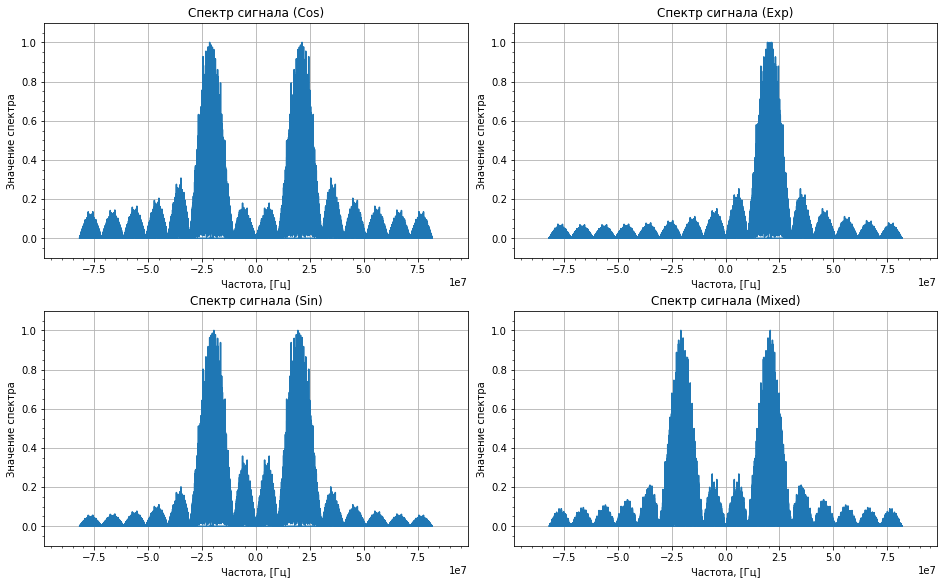

In [41]:
plt.figure(figsize=(13, 8), constrained_layout=True)

sp = plt.subplot(221)
plt.plot(fftCos[0], np.abs(fftCos[1])) 
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение спектра")
plt.title("Спектр сигнала (Cos)")
plt.minorticks_on()
plt.grid(True)

sp = plt.subplot(222)
plt.plot(fftExp[0], np.abs(fftExp[1])) 
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение спектра")
plt.title("Спектр сигнала (Exp)")
plt.minorticks_on()
plt.grid(True)

sp = plt.subplot(223)
plt.plot(fftSin[0], np.abs(fftSin[1])) 
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение спектра")
plt.title("Спектр сигнала (Sin)")
plt.minorticks_on()
plt.grid(True)

sp = plt.subplot(224)
plt.plot(fftMixed[0], np.abs(fftMixed[1])) 
plt.margins(0.1, 0.1)
plt.xlabel("Частота, [Гц]") 
plt.ylabel("Значение спектра")
plt.title("Спектр сигнала (Mixed)")
plt.minorticks_on()
plt.grid(True)

## 5.5 Осциллограммы I и Q составляющих 

In [ ]:
plt.figure(figsize=(13, 6), constrained_layout=True)

#subplot 1
sp = plt.subplot(211)
plt.plot(time[:200], signalSin[:200])
plt.step(time[:200], code_samples_2[:200], where = 'post')
plt.xlabel(r'$t\ [c]$')
plt.ylabel(r'$Amplitude$')
plt.title(r'$signalSin$')
plt.minorticks_on()
plt.grid(True)

#subplot 2
sp = plt.subplot(212)
plt.plot(time[:200], signalCos[:200])
plt.step(time[:200], code_samples_1[:200], where = 'post')
plt.xlabel(r'$t\ [c]$')
plt.ylabel(r'$Amplitude$')
plt.title(r'$signalCos$')
plt.minorticks_on()
plt.grid(True)

## 5.6 Анимация квадратурного уплотнения 

### 5.6.1 Отображение вращения векторных составляющих I и Q

In [ ]:
# Позиционные массивы
%matplotlib notebook 
x_Q = np.sin(0 * time)
y_Q = signalSin

x_I = signalCos
y_I = np.sin(0 * time) 

# Задаем набор данных для анимации
dataSet_Q = np.array([x_Q, y_Q])  # Комбинируем наши позиционные координаты
dataSet_I = np.array([x_I, y_I])  # Комбинируем наши позиционные координаты
numDataPoints = len(time[:5000])

def animate_func(num):
    ax1.clear()  # Очищаем фигуру для обновления линии, точки, 
    
    p = np.linspace(0,np.pi*2,100)
    ax1.plot(np.cos(p), np.sin(p), linewidth=1)
    
    ax1.plot(dataSet_Q[0, 0], dataSet_Q[1, 0], c='black', marker='o') 
    
    if(dataSet_Q[1, num] >= 0):
        ax1.scatter(dataSet_Q[0, num], dataSet_Q[1, num], c='blue', marker='^')    # Добавляем постоянную начальную точку
    else:
        ax1.scatter(dataSet_Q[0, num], dataSet_Q[1, num], c='blue', marker='v')
        
    ax1.plot([dataSet_Q[0, 0], dataSet_Q[0,num]],
            [dataSet_Q[1, 0] ,dataSet_Q[1,num]], c='blue')
    
    if(dataSet_I[0, num] >= 0):
        ax1.scatter(dataSet_I[0, num], dataSet_I[1, num], c='red', marker='>')    # Добавляем постоянную начальную точку
    else:
        ax1.scatter(dataSet_I[0, num], dataSet_I[1, num], c='red', marker='<')
        
    ax1.plot([dataSet_Q[0, 0], dataSet_I[0,num]],
            [dataSet_Q[1, 0] ,dataSet_I[1,num]], c='red')
    
    ax1.scatter(dataSet_I[0, num], dataSet_Q[1, num], c='black', marker='o')
        
    ax1.plot([dataSet_Q[0, 0], dataSet_I[0,num]],
            [dataSet_Q[1, 0] ,dataSet_Q[1,num]], c='black')
    
    ax1.plot([dataSet_I[0, num], dataSet_I[0,num]],
            [dataSet_I[1, num] ,dataSet_Q[1,num]], 'k--')
    
    ax1.plot([dataSet_Q[0, num], dataSet_I[0,num]],
            [dataSet_Q[1, num] ,dataSet_Q[1,num]], 'k--')
    
    ax1.set_xlim([-1, 1]) # Задаем пределы для осей
    ax1.set_ylim([-1, 1])

    # Добавляем метки
    ax1.set_title('Mixed Signal \nTime = ' + str(time[num]) + ' sec')
    ax1.set_xlabel('I quadrature')
    ax1.set_ylabel('Q quadrature')
    ax1.grid(1)

### 5.6.2 Отображение смены бит составляющих I и Q

In [ ]:
# Позиционные массивы
x_Q = np.sin(0 * time)
y_Q = code_samples_2

x_I = code_samples_1
y_I = np.sin(0 * time) 

# Задаем набор данных для анимации
dataSet_Q_bits = np.array([x_Q, y_Q])  # Комбинируем наши позиционные координаты
dataSet_I_bits = np.array([x_I, y_I])  # Комбинируем наши позиционные координаты

def animate_func2(num):
    ax2.clear()  # Очищаем фигуру для обновления линии, точки, 
    
    p = np.linspace(0,np.pi*2,100)
    ax2.plot(np.cos(p), np.sin(p), linewidth=1)
    
    ax2.plot(0, 0, c='black', marker='o') 
    
    if(dataSet_Q_bits[1, num] >= 0):
        ax2.scatter(dataSet_Q_bits[0, num], dataSet_Q_bits[1, num]/np.sqrt(2),
                   c='blue', marker='^')    # Добавляем постоянную начальную точку
    else:
        ax2.scatter(dataSet_Q_bits[0, num], dataSet_Q_bits[1, num]/np.sqrt(2),
                   c='blue', marker='v')
        
    ax2.plot([0, dataSet_Q_bits[0,num]],
            [0 ,dataSet_Q_bits[1,num]/np.sqrt(2)], c='blue')
    
    if(dataSet_I_bits[0, num] >= 0):
        ax2.scatter(dataSet_I_bits[0, num]/np.sqrt(2), dataSet_I_bits[1, num],
                   c='red', marker='>')    # Добавляем постоянную начальную точку
    else:
        ax2.scatter(dataSet_I_bits[0, num]/np.sqrt(2), dataSet_I_bits[1, num],
                   c='red', marker='<')
        
    ax2.plot([0, dataSet_I_bits[0,num]/np.sqrt(2)],
            [0,dataSet_I_bits[1,num]], c='red')
    
    
    ax2.scatter(dataSet_I_bits[0, num]/np.sqrt(2), dataSet_Q_bits[1, num]/np.sqrt(2),
               c='black', marker='o')
        
    ax2.plot([0, dataSet_I_bits[0,num]/np.sqrt(2)],
            [0,dataSet_Q_bits[1,num]/np.sqrt(2)], c='black')
    
    ax2.plot([dataSet_I_bits[0, num]/np.sqrt(2), dataSet_I_bits[0,num]/np.sqrt(2)],
            [dataSet_I_bits[1, num]/np.sqrt(2), dataSet_Q_bits[1,num]]/np.sqrt(2), 'k--')
    
    ax2.plot([dataSet_Q_bits[0, num]/np.sqrt(2), dataSet_I_bits[0,num]/np.sqrt(2)],
            [dataSet_Q_bits[1, num], dataSet_Q_bits[1,num]]/np.sqrt(2), 'k--')
    
    ax2.set_xlim([-1, 1]) # Задаем пределы для осей
    ax2.set_ylim([-1, 1])

    # Добавляем метки
    ax2.set_title('Mixed Signal \nTime = ' + str(time[num]) + ' sec')
    ax2.set_xlabel('I quadrature')
    ax2.set_ylabel('Q quadrature')
    ax2.grid(1)

### 5.6.3 Непосредственно анимации 

In [ ]:
# Рисуем анимацию
fig1 = plt.figure(figsize=(8, 7), constrained_layout=True)
ax1 = plt.axes()
line_ani = animation.FuncAnimation(fig1, animate_func, interval=250,  
                                  frames=numDataPoints)
plt.show()

In [ ]:
f = r"c://Users/User/Desktop/animate_func.gif"
writergif = animation.PillowWriter(fps=numDataPoints/10)
line_ani.save(f, writer=writergif)

In [ ]:
# Рисуем анимацию
fig2 = plt.figure(figsize=(8, 7), constrained_layout=True)
ax2 = plt.axes()
line_ani = animation.FuncAnimation(fig2, animate_func2, interval=100,  
                                  frames=numDataPoints)
plt.show()

In [ ]:
f = r"c://Users/User/Desktop/animate_func2.gif"
writergif = animation.PillowWriter(fps=numDataPoints/5)
line_ani.save(f, writer=writergif)